# Etude de la compressibilité sous une transition de phase

#### L'idée est ici la suivante : on étudie la compressibilité sous une transition de phase, en faisant varier la température. De là, on peut déduire, en faisant boucler sur $\rho$ depuis la formule de la compressibilité des isothermes entre P et rho/V.

## Importation des librairies et des routines

In [1]:
# Import standard libraries
import numpy as np
from scipy.special import gamma
import matplotlib.pyplot as plt
from matplotlib import animation, cm, colors, rc
import random
import time
from imp import reload
rc('animation', html='html5')

# Import library of our own functions
import MPCMolecularDynamics as MD
reload(MD)
from library1 import *

#Include plots into notebook instead of plotting them in extra window
%matplotlib inline 

## Une première trajectoire

In [8]:
# define system
d=2
NParticles=16
kT = 0.34
m = np.ones(NParticles)

# Lennard-Jones
sigma = 1
epsilon = 1
tau = sigma*np.sqrt(m[0]/epsilon) #unit of time
print('tau=',tau)

# choose density
rho = 0.5/sigma**d
print('Densité=', rho, 'sigma**',d)
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 100. * tau

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

( t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr, pHyper_tr,[t,x,y,vx,vy] 
) = Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time)

print("Execution time: ",time.perf_counter() - initialWallTime)

tau= 1.0
Densité= 0.5 sigma** 2
LBox =  5.656854249492381
Execution time:  32.77153052099993


Animation de la trajectoire générée:

1


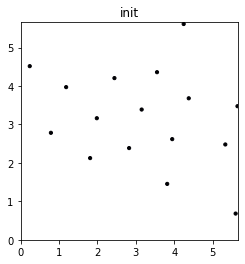

In [3]:
# t_tr contains the times corresponding to the stored energies and pressures, 
# but onfigurations were stored less frequently

# As a consequence we need to skip all the intermediate times in t_tr 
# for which we have no data in x_tr and y_tr
#skip=int( (t_tr.size-1)/(x_tr.shape[0]-1) )
skip=1
print(skip)

MD.AnimateMDRun(t_tr[::skip],x_tr,y_tr,xBox=LBox,xpbc=True,yBox=LBox,ypbc=True,m=m)

Plot des trajectoires des différentes particules

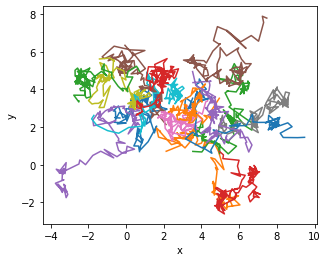

In [4]:
ax = plt.axes()
MD.AddParticleTraces(ax,x_tr,y_tr,range(NParticles))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

## Pression de Virial et compressibilité 

La compressibilité peut être déduite des fluctuations de la pression de Virial:

\begin{equation}
\langle \delta {\cal P}^2 \rangle_{NVT} = \frac{k_BT}{V} \left( \frac{2 N k_BT}{d V} +  \langle {\cal P} \rangle_{NVT} -\beta_T^{-1}  + \frac1V \langle {\cal X} \rangle_{NVT} \right)
\end{equation}

où
\begin{equation}
{\cal P} 
= \frac1{d V} \left[ \sum_i m_i \left|\vec v_i \right|^2 
                    + \sum_{i<j} \vec f_{ij}\cdot\vec r_{ij} \right]
\end{equation}

On peut aussi défini la pression comme : 
\begin{equation}
{\cal P'} 
= \rho k_BT + \frac1{d V} \left[  \sum_{i<j} \vec f_{ij}\cdot\vec r_{ij} \right]
= \rho k_BT + \frac1{V} \langle {\cal W} \rangle
\end{equation}

Dans ce cas : 

\begin{equation}
\langle \delta {\cal P'}^2 \rangle_{NVT} = \frac{k_BT}{V} \left( \langle {\cal P'} \rangle_{NVT} -\beta_T^{-1}  + \frac1V \langle {\cal X} \rangle_{NVT} \right)
\end{equation}


Référence:

    M. Allen and D. Tildesley, Computer Simulations of Liquids, 2nd Edition, Oxford (2017), pp. 60-69

En résolvant les équations ci-dessus on obtient une expression de la compressibilité:

\begin{equation}
\beta_T^{-1} 
 =  \frac{2 N k_BT}{d V} - \frac{V}{k_BT} \langle \delta {\cal P}^2 \rangle_{NVT} +  \langle {\cal P} \rangle_{NVT}   + \frac1V \langle {\cal X} \rangle_{NVT} 
\end{equation}

et

\begin{equation}
\beta_T^{-1} 
 =   - \frac{V}{k_BT} \langle \delta {\cal P'}^2 \rangle_{NVT} +  \langle {\cal P'} \rangle_{NVT}   + \frac1V \langle {\cal X} \rangle_{NVT} 
\end{equation}


### Pression et compressibilité pour une trajectoire dans l'espace des phases

In [4]:
# define system
d=2
NParticles=16
kT = 0.34
m = np.ones(NParticles)

# Lennard-Jones
sigma = 1
epsilon = 1
tau = sigma*np.sqrt(m[0]/epsilon) #unit of time
print('tau=',tau)

# choose density
rho = 0.5/sigma**d
print('Densité=', rho, 'sigma**',d)
LBox = np.power(NParticles/rho,1./d)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 100. * tau

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

( t_tr, x_tr, y_tr, vx_tr, vy_tr, uPot_tr, uKin_tr, pPot_tr, pKin_tr, pHyper_tr, [t,x,y,vx,vy] 
) = Generate_LJ_NVT_MolecularDynamics_Trajectory(d,m,LBox,kT,run_time)

print("Execution time: ",time.perf_counter() - initialWallTime)

tau= 1.0
Densité= 0.5 sigma** 2
LBox =  5.656854249492381
Execution time:  11.583619684000041


On peut alors obtenir la compressibilité pour une trajctoire : 

In [5]:
Compressibility_from_pressure_fluctuations_in_NVT(d,m,NParticles,LBox,kT,pPot_tr, pHyper_tr)

-0.06489528835169674

### Génération d'un ensemble de trajectoires à $kT$ et $\rho$ fixés

In [10]:
# define system
NParticles=16
d=2
kT = .5
m = np.ones(NParticles)
sigma = 1
epsilon = 1
#unit of time
tau = sigma*np.sqrt(m[0]/epsilon)      

# density
rho = 0.5/sigma**d
LBox = np.power(NParticles/rho,1/2)
print('kT=',kT)
print('rho=',rho)
print("LBox = ",LBox)

# define the length of the trajectory
run_time = 100. * tau

# define number of independent trajectories
NTrajectories = 5
print('Nombre de simulations:', NTrajectories)

# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

(t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
 uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens, pHyper_tr_ens,
 list_of_starting_configurations
) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,run_time)

print("Execution time: ",time.perf_counter() - initialWallTime)

kT= 0.5
rho= 0.5
LBox =  5.656854249492381
Nombre de simulations: 5
Execution time:  63.85386376000042


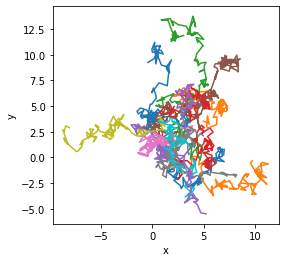

In [11]:
#Tracé de la trajectoire des particules pour 1 simulation, check up
ax = plt.axes()
Traj=1
MD.AddParticleTraces(ax,x_tr_ens[Traj],y_tr_ens[Traj],range(NParticles))
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect(1)
plt.show()

Ici on a une fonction qui renvoie directement la moyenne des compressibilités et l'écart type divisé par le nombre de trajectoires

In [12]:
Compressibility_from_pressure_fluctuations_in_NVT(d,m,NParticles,LBox,kT,pPot_tr_ens, pHyper_tr_ens)

(-0.08427249344362622, 0.0022977628370222944)

### Balayage en température à $\rho$ fixé

In [17]:
rho_range=np.array([0.5])
kT_range = np.linspace(0.1,1,15)
print(kT_range)

[0.1        0.16428571 0.22857143 0.29285714 0.35714286 0.42142857
 0.48571429 0.55       0.61428571 0.67857143 0.74285714 0.80714286
 0.87142857 0.93571429 1.        ]


In [18]:
# When in doubt use a small number of particles to speed up the simulations
# In a perfect world (as opposed to an exam), we would generate data for different systems sizes 
# and study finite size effects.

NParticles = 32
m = np.ones(NParticles)
d = 2

# Not much fun, if we reduce this even further
NTrajectories = 10
run_time_equilibration = 2
run_time_data_acquisition = 20

print("One sweep over all state points corresponds to ", rho_range.size * kT_range.size * NTrajectories," separate simulations!")

# On my computer each of the for "sweeps" below took 2 minutes. If you are worried about time try first with
# NTrajectories = 1

One sweep over all state points corresponds to  150  separate simulations!


In [19]:
# Create empty dictionaries for the data generated by MD simulations at specific state points
t_tr_ens_from_NVT_heating = {}
x_tr_ens_from_NVT_heating = {}
y_tr_ens_from_NVT_heating = {}
vx_tr_ens_from_NVT_heating = {}
vy_tr_ens_from_NVT_heating = {}
uPot_tr_ens_from_NVT_heating = {}
uKin_tr_ens_from_NVT_heating = {}
pPot_tr_ens_from_NVT_heating = {}
pKin_tr_ens_from_NVT_heating = {}
pHyper_tr_ens_from_NVT_heating = {}
list_of_starting_configurations_from_NVT_heating = {}


# generate trajectories and measure execution time
initialWallTime = time.perf_counter()

# sweep over densities
for rho in rho_range:
    
    # re-initialize starting configurations
    list_of_starting_configurations=[]
    for n in range(NTrajectories): 
            list_of_starting_configurations.append([])    
    

    # sweep over temperatures
    for kT in kT_range:
        i=0
        print("rho = ",rho,", kT = ",kT)
        
        # Box size
        LBox = np.power(NParticles/rho,1./d)


        # Equilibrate
        # ... reset velocities more often and hope for the best
        (t_tr_ens, x_tr_ens, y_tr_ens, vx_tr_ens, vy_tr_ens,
         uPot_tr_ens, uKin_tr_ens, pPot_tr_ens, pKin_tr_ens, pHyper_tr_ens,
         list_of_starting_configurations
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_equilibration,
                                                                       list_of_starting_configurations=list_of_starting_configurations,
                                                                       number_of_time_steps_between_velocity_resets=10)

        key = (NParticles,str(round(rho,3)),str(round(kT,2)))
        # using floats as key can lead to difficulties, because of their inexact representation
        print('key=',key)
                # Generate data
        run_time = 50. *tau
        (t_tr_ens_from_NVT_heating[key], 
         x_tr_ens_from_NVT_heating[key], 
         y_tr_ens_from_NVT_heating[key], 
         vx_tr_ens_from_NVT_heating[key], 
         vy_tr_ens_from_NVT_heating[key],
         uPot_tr_ens_from_NVT_heating[key], 
         uKin_tr_ens_from_NVT_heating[key], 
         pPot_tr_ens_from_NVT_heating[key], 
         pKin_tr_ens_from_NVT_heating[key],
         pHyper_tr_ens_from_NVT_heating[key],
         list_of_starting_configurations_from_NVT_heating[key]
        ) = Generate_Ensemble_of_LJ_NVT_MolecularDynamics_Trajectories(d,m,LBox,kT,NTrajectories,
                                                                       run_time_data_acquisition,
                                                                       list_of_starting_configurations=list_of_starting_configurations)

print("Execution time: ",time.perf_counter() - initialWallTime)

rho =  0.5 , kT =  0.1
key= (32, '0.5', '0.1')
rho =  0.5 , kT =  0.1642857142857143
key= (32, '0.5', '0.16')
rho =  0.5 , kT =  0.2285714285714286
key= (32, '0.5', '0.23')
rho =  0.5 , kT =  0.2928571428571429
key= (32, '0.5', '0.29')
rho =  0.5 , kT =  0.3571428571428572
key= (32, '0.5', '0.36')
rho =  0.5 , kT =  0.4214285714285715
key= (32, '0.5', '0.42')
rho =  0.5 , kT =  0.48571428571428577
key= (32, '0.5', '0.49')
rho =  0.5 , kT =  0.55
key= (32, '0.5', '0.55')
rho =  0.5 , kT =  0.6142857142857143
key= (32, '0.5', '0.61')
rho =  0.5 , kT =  0.6785714285714286
key= (32, '0.5', '0.68')
rho =  0.5 , kT =  0.7428571428571429
key= (32, '0.5', '0.74')
rho =  0.5 , kT =  0.8071428571428572
key= (32, '0.5', '0.81')
rho =  0.5 , kT =  0.8714285714285716
key= (32, '0.5', '0.87')
rho =  0.5 , kT =  0.9357142857142858
key= (32, '0.5', '0.94')
rho =  0.5 , kT =  1.0
key= (32, '0.5', '1.0')
Execution time:  1313.7878609180007


In [20]:
pHyper_tr_ens_from_NVT_heating

{(32,
  '0.5',
  '0.1'): array([[-0.95717388, -0.96527024, -0.975412  , ...,  0.07519832,
          0.04942127,  0.02714245],
        [-0.87044596, -0.86915993, -0.86842935, ..., -0.66252997,
         -0.68912833, -0.71263723],
        [-0.99903464, -1.00960115, -1.01998363, ..., -0.18042499,
         -0.21475684, -0.24467184],
        ...,
        [-1.01242232, -1.02164286, -1.03326606, ..., -0.39344909,
         -0.38216537, -0.36581592],
        [-1.14384821, -1.15253414, -1.16076196, ...,  0.09123145,
          0.09066593,  0.08717554],
        [-1.01553165, -1.01182826, -1.01060205, ..., -0.4152134 ,
         -0.40193054, -0.38793405]]),
 (32,
  '0.5',
  '0.16'): array([[-0.16308675, -0.13053358, -0.10978486, ..., -0.60997944,
         -0.60962145, -0.5857167 ],
        [-0.22386767, -0.23705758, -0.25636254, ..., -0.07115464,
         -0.06544718, -0.08100781],
        [-0.11895075, -0.09024684, -0.059646  , ..., -0.41600629,
         -0.37885684, -0.3348321 ],
        ...,
     

In [21]:
compressibility_from_NVT_heating=[]

#Compressibility_from_pressure_fluctuations_in_NVT(d,m,NParticles,LBox,kT,pPot_tr_ens, pHyper_tr_ens)

for i in range(len(kT_range)):
    
    key=((NParticles,str(round(rho,3)),str(round(kT_range[i],2))))
    print(key)
    compr_Ntraj_fixedkT = Compressibility_from_pressure_fluctuations_in_NVT(d,m,NParticles,LBox,kT,pPot_tr_ens_from_NVT_heating[key], pHyper_tr_ens_from_NVT_heating[key])
    print(compr_Ntraj_fixedkT)
    compressibility_from_NVT_heating.append(compr_Ntraj_fixedkT)
    
print(compressibility_from_NVT_heating)

(32, '0.5', '0.1')
(-0.24813583574870704, 0.015482680137545807)
(32, '0.5', '0.16')
(-0.3214171172891595, 0.02919728462159281)
(32, '0.5', '0.23')
(-0.2328570981874593, 0.008083917073243066)
(32, '0.5', '0.29')
(-0.20026294664493785, 0.01020731398083923)
(32, '0.5', '0.36')
(-0.16491454162300576, 0.004997513346759167)
(32, '0.5', '0.42')
(-0.15165738989586627, 0.005666022954444245)
(32, '0.5', '0.49')
(-0.14886257458776977, 0.0031038911577291363)
(32, '0.5', '0.55')
(-0.1396756534578587, 0.0035110773151496026)
(32, '0.5', '0.61')
(-0.13861189796733722, 0.002947150616899857)
(32, '0.5', '0.68')
(-0.13568016355941606, 0.005795815386781847)
(32, '0.5', '0.74')
(-0.11860684205773782, 0.0036863594638454167)
(32, '0.5', '0.81')
(-0.1067297057664384, 0.00467563983595473)
(32, '0.5', '0.87')
(-0.09840768586710322, 0.0024131283826295618)
(32, '0.5', '0.94')
(-0.09260330828957761, 0.0015733293609814568)
(32, '0.5', '1.0')
(-0.09068742844230618, 0.0031667486432121164)
[(-0.24813583574870704, 0.01

In [22]:
mean_compressibility_from_NVT_heating=[]
dispersion_compressibility_from_NVT_heating=[]
for i in range(len(kT_range)):
    mean_compressibility_from_NVT_heating.append(compressibility_from_NVT_heating[i][0])
    dispersion_compressibility_from_NVT_heating.append(compressibility_from_NVT_heating[i][1])

Text(0.5, 0, 'Température')

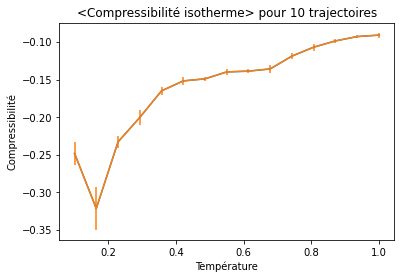

In [24]:
plt.plot(kT_range,mean_compressibility_from_NVT_heating)
plt.errorbar(kT_range,mean_compressibility_from_NVT_heating,dispersion_compressibility_from_NVT_heating)
plt.title('<Compressibilité isotherme> pour {} trajectoires'.format(NTrajectories))
plt.ylabel('Compressibilité')
plt.xlabel('Température')

On a :

$\mathrm{d} V=-\chi_{T} V \mathrm{~d} P$

On peut alors comparer avec le diagramme de compressibilité isohterme de l'eau par exemple (*attention, le diagramme est en Farheneits*) : 
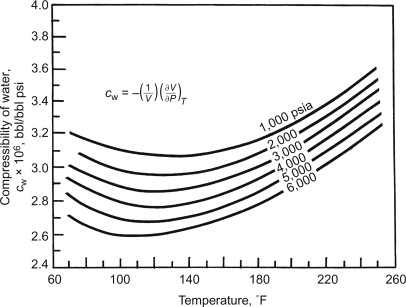

On peut alors en déduire que la compressibiltié isotherme semble bien être une fonction de la température ainsi que de la pression de l'environnement. Il semble qu'elle présente dans notre cas un minimum pour un $0,1<kT<0,2$.

Revenons alors aux formules des compressibilités isothermes. Comparons les compressibilités isothermes de deux équations d'état : celle de Van der Waals et celle du gaz parfait. Dans le premier cas, on a : 

$\chi_{T}(T, \bar{V})=\frac{\bar{V}}{R T} \frac{\left(1-\frac{b}{\bar{V}}\right)^{2}}{\left(1-\frac{2 a(\bar{V}-b)^{2}}{R T \bar{V}^{3}}\right)}$

et dans le second cas: 

$\chi_{T}=-\frac{1}{V}\left(\frac{\partial V}{\partial P}\right)_{T}=\frac{1}{P} = \frac{V}{NRT}$

On peut alors tracer ces deux fonctions de $T$, et comparer avec l'allure de notre courbe.

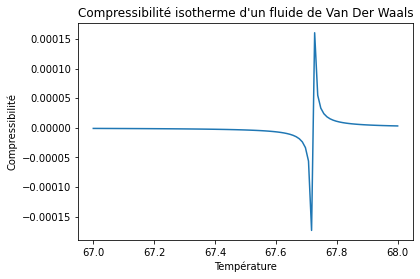

In [24]:
#For azote : 

a = 0.133 
b = 3.744*10**(-5)
Vmol = 0.575*10**(-4)
R = 8.314

def compressibilite_vdw(x):
    res = 0
    res = Vmol/(R*x)
    res = res*((1-(b/Vmol))**2)
    res = res/(1-((2*a)*((Vmol-b)**2))/(R*x*(Vmol)**3))
    return res

x=np.linspace(67,68,100)
plt.plot(x,compressibilite_vdw(x))
plt.title("Compressibilité isotherme d'un fluide de Van Der Waals")
plt.ylabel('Compressibilité')
plt.xlabel('Température')
plt.show()

<ipython-input-25-2443a48a8fb9>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(x,(Vmol*R/x))  # on utilise la fonction sinus de Numpy


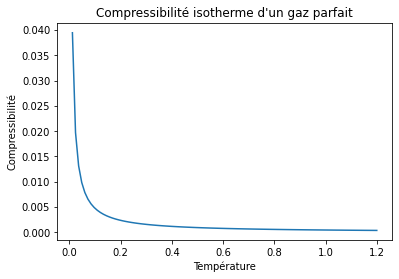

In [25]:
x=np.linspace(0,1.2,100)
plt.plot(x,(Vmol*R/x))  # on utilise la fonction sinus de Numpy
plt.title("Compressibilité isotherme d'un gaz parfait")
plt.ylabel('Compressibilité')
plt.xlabel('Température')
plt.show()

On s'aperçoit que notre fluide est beaucoup plus proche en vérité d'un fluide de Van Der Waals que d'un fluide parfait, ce qui colle avec les choix pris au début de la simulation (fluide de Lennard-Jones). On peut cependant apporter quelques éclaircissements quand à la disparition de la divergence et au changement d'allure de la courbe au delà de celle-ci : 

* La divergence semble disparaître dans le cadre de notre simulation. Cette divergence peut donc dûe à l'absence d'interaction dans le fluide de Van Der Waals, et les interactions peuvent jouer un rôle dans la compressibilité.

* L'allure réelle de notre courbe est probablement faussée par un biais d'échantillonnage qui ne rend pas effectivement compte de la compressibilité autour de la "divergence".

Il faut avoir enfin un débat sur comment nous pouvons exploiter ce diagramme. On peut difficilement y repérer une transition de phase (cf. le diagramme de l'eau). Le minimum de la compressibilité n'indique pas grand chose par exemple. Cependant, la formule ainsi que l'allure de la courbe nous ammnènent à penser que la compressibilité peut fournir un autre moyen de tracer les isothermes de Clapeyron. En effet, si nous bouclions sur $\rho$ (cf. d'autres Jupyter) les routines, nous pourrions tracer des isothermes via la formule $\chi_{T}=\frac{1}{\rho}\left(\frac{\partial \rho}{\partial P}\right)_{T}$